This is my notebook used to analyse the usage data available at https://cycling.data.tfl.gov.uk/ from December 30th 2020 - December 01 2023.

This notebook will involve EDA, feature engineering, and modelling to aid with understanding complex patterns within the data, and how this may inform decision making to drive maximum value for the client in their endeavour.

This notebook contains the main "data science" portion of the task, it is important to investigate the other .ipynb I used to reorganise most of the original data, and remove most of the redundant columns whilst retaining information - "scraped_data_preprocessing.ipynb". I have left some of said feature cleaning for this notebook also, to provide insight into how I went about this task in this notebook too.



In [1]:
# data science tools and utilities
import pandas as pd
import numpy as np

#model tools
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#visuals
%matplotlib inline
from matplotlib import pyplot as plt


#colab tools to read csv file
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/processed_cycling.csv"

Mounted at /content/drive


In [2]:
#loading in data
df = pd.read_csv(path, low_memory=False)

In [3]:
#initial examination
df.head()

,Duration,Bike Id,Bike number,Bike model,Total duration,Total duration (ms),Number ID,Start,End,Start station code,End station code,Start Station,End Station
0,1620.0,22.0,NaN,NaN,NaN,NaN,104820582.0,2021-03-01 14:47:00,2021-03-01 15:14:00,542.0,11.0,"Salmon Lane, Limehouse","Brunswick Square, Bloomsbury"
1,1740.0,10755.0,NaN,NaN,NaN,NaN,104816169.0,2021-03-01 12:57:00,2021-03-01 13:26:00,546.0,542.0,"New Fetter Lane, Holborn","Salmon Lane, Limehouse"
2,1620.0,18908.0,NaN,NaN,NaN,NaN,104757113.0,2020-12-30 14:33:00,2020-12-30 15:00:00,779.0,239.0,"Houndsditch, Aldgate","Warren Street Station, Euston"
3,780.0,18499.0,NaN,NaN,NaN,NaN,104749458.0,2020-12-30 09:08:00,2020-12-30 09:21:00,653.0,766.0,"Simpson Street, Clapham Junction","Ram Street, Wandsworth"
4,5400.0,15668.0,NaN,NaN,NaN,NaN,104788389.0,2021-01-01 14:59:00,2021-01-01 16:29:00,655.0,655.0,"Crabtree Lane, Fulham","Crabtree Lane, Fulham"


In [4]:
#size of dataset, and the columns we are working with
print(f'{df.shape} \n')
print(f'{df.dtypes} \n')

(30313809, 13) 

Duration               float64
Bike Id                float64
Bike number            float64
Bike model              object
Total duration          object
Total duration (ms)    float64
Number ID              float64
Start                   object
End                     object
Start station code     float64
End station code       float64
Start Station           object
End Station             object
dtype: object 



Looking at the structure of the dataset:

\

*   Start Station and End Station are likely to be useful, this could potentially determine areas of high bicycle requirements. Which could aid strategy formation in terms of knowing what places are high impact.

*   It's very likely the start and end time difference is due to distance between the stations.

*   It seems a number of entries are missing a Bike Model and Bike Number, it may be possible to infer from entries that contain these data what other bike models may be based on the bike id

*   Bike number and Bike Id are likely to conflict, maybe entries that lack a Bike Number have a Bike Id. If these entries are the same, we can create a single column containing all Id.

*   The Number ID column is an interesting discussion, as it does not appear to be a substitution for Bike Id. At first glance this may be a sort of "Journey ID".

*   It appears the Duration column, is the difference between Start and End times, converted to seconds. It may be worthwhile converting this to a minute format for readability. There is also implications for the Total Duration and Total Duration (ms) columns.

\
There are also some clear directions for data science usage:

\

1.   Modelling - An initial idea for modelling could be spatio-temporal modelling, which allows consideration of factors such as geographical location, and usage statistics to draw insights. Tools like regression or classification models will serve little purpose here.

2.   Thorough Exploratory Analysis - Exploring this dataset, and trying to understand things like the average distance time, most frequent stations, and other factors may be the most effective way to draw insights from this dataset, which given the size, will likely provide great insight into how to leverage these key pieces of information.

3. Identifying most prominent Bicycle models - Whilst it appears a considerable chunk of the dataset may be lacking this value, it is important to still examine the entries that do exist, and get a feel for what bicycle models are most prominent. There may also be interesting insights gained from this in relation to a bicycle model x being more popular for certain types of stations.








In [5]:
#first, let's investigate how duration and  the total duration columns differ
print('Example objects in each column:\n')
print(df['Duration'].head())
print(df['Total duration'].tail())
print(df['Total duration (ms)'].tail())

print('\nNaN Values for each column:\n')
print('NaN entries in Duration: ', df['Duration'].isna().sum())
print('NaN entries in Total duration', df['Total duration'].isna().sum())
print('NaN entries in Total duration (ms)', df['Total duration (ms)'].isna().sum())

Example objects in each column:

0    1620.0
1    1740.0
2    1620.0
3     780.0
4    5400.0
Name: Duration, dtype: float64
30313804      5m 0s
30313805    22m 17s
30313806    24m 55s
30313807      5m 8s
30313808    15m 30s
Name: Total duration, dtype: object
30313804     300231.0
30313805    1337181.0
30313806    1495092.0
30313807     308122.0
30313808     930625.0
Name: Total duration (ms), dtype: float64

NaN Values for each column:

NaN entries in Duration:  10586532
NaN entries in Total duration 19727277
NaN entries in Total duration (ms) 19727277


So it seems they all take differing formats as a result of the data format change. I believe minutes would be the best metric here, as seconds/milliseconds could be quite cluttered as they hit larger sizes, and minutes are a much more readable metric.

Furthermore, it does appear the columns missing a 'Duration' entry, do include a 'Total duration' entry. Meaning after converting to a unified format, we will have an entry for every row.


Let's handle that next

In [6]:
#simple conversion of duration
df['Duration'] = df['Duration'] / 60.0

def total_duration_to_minutes(time_str):
    if pd.isna(time_str):
        return np.nan
    parts = time_str.replace('d', ' ').replace('h', ' ').replace('m', ' ').replace('s', ' ').split()
    days, hours, minutes, seconds = 0, 0, 0, 0
    if len(parts) == 4:
        days, hours, minutes, seconds = map(float, parts)
    elif len(parts) == 3:
        hours, minutes, seconds = map(float, parts)
    elif len(parts) == 2:
        minutes, seconds = map(float, parts)
    elif len(parts) == 1:
        minutes = float(parts[0])
    else:
        raise ValueError(f"Invalid time format: '{time_str}'")
    #return the minutes
    return days * 24 * 60 + hours * 60 + minutes + seconds / 60.0

#converting total duration with the function, can take awhile given size
df['Total duration'] = df['Total duration'].apply(total_duration_to_minutes)


In [7]:
#combining columns into a unified Duration(Minutes) column
df['Duration(Minutes)'] = df['Duration'].combine_first(df['Total duration'])

#removing redundant Duration columns as a result
df = df.drop(['Duration', 'Total duration', 'Total duration (ms)'], axis=1)

#rounding minutes for good measure
df['Duration(Minutes)'] = df['Duration(Minutes)'].round()

#examining result
df.head()

,Bike Id,Bike number,Bike model,Number ID,Start,End,Start station code,End station code,Start Station,End Station,Duration(Minutes)
0,22.0,NaN,NaN,104820582.0,2021-03-01 14:47:00,2021-03-01 15:14:00,542.0,11.0,"Salmon Lane, Limehouse","Brunswick Square, Bloomsbury",27.0
1,10755.0,NaN,NaN,104816169.0,2021-03-01 12:57:00,2021-03-01 13:26:00,546.0,542.0,"New Fetter Lane, Holborn","Salmon Lane, Limehouse",29.0
2,18908.0,NaN,NaN,104757113.0,2020-12-30 14:33:00,2020-12-30 15:00:00,779.0,239.0,"Houndsditch, Aldgate","Warren Street Station, Euston",27.0
3,18499.0,NaN,NaN,104749458.0,2020-12-30 09:08:00,2020-12-30 09:21:00,653.0,766.0,"Simpson Street, Clapham Junction","Ram Street, Wandsworth",13.0
4,15668.0,NaN,NaN,104788389.0,2021-01-01 14:59:00,2021-01-01 16:29:00,655.0,655.0,"Crabtree Lane, Fulham","Crabtree Lane, Fulham",90.0


The conversion has worked and we have a unified duration in minutes column to work with now.

the duration column we have created, appears to be the only one with potential outliers. For instance some bikes may have been left and not returned to a station, and such data would harm any insights.

Taking a sensible estimation, let's have a look at the duration time statistics. This will guide what constitutes as an "Outlier". It's important to also keep in mind the distance between some places will of course be the main contributing factor here, but it still provides great insight into the distance renters will be willing to traverse.

In [8]:
#getting mean duration length
print('Average duration', df.loc[:, 'Duration(Minutes)'].mean().round())

#quantiles
duraiton_quantiles = df['Duration(Minutes)'].quantile([0.25,0.5,0.75,0.95])
print(f' Quantiles of the duration column: {duraiton_quantiles}')

Average duration 23.0
 Quantiles of the duration column: 0.25     8.0
0.50    14.0
0.75    22.0
0.95    48.0
Name: Duration(Minutes), dtype: float64


Seems like anything over 48 can be deemed as an outlier, and it's reasonable to assume some individuals may use a bicycle for close to an hour in a large city like London.

With this in mind, we will remove any rows with a duration value exceeding 48 minutes.


In [9]:
#removing rows exceeding 48 minutes of duration
df = df[df['Duration(Minutes)'] <= 48]

Next, let's see how much of the data contains a 'Bike model' value. Bike number is not likely to be too helpful, but it is worth to maybe check this also.

In [10]:
#unique entries for Bike models
print('Unique entries for Bike model: ', df['Bike model'].unique())

#entries with NaN values for Bike model
print('Count of NaN entries for Bike model: ', df['Bike model'].isna().sum())

#entries with a non-NaN Bike model
print('Count of non-NaN entries for Bike model: ', df['Bike model'].notna().sum())

print()

#let's also see if the bike number is arbitrary
print('Number of unique entries for Bike number: ', len(df['Bike number'].unique()))

#entries with NaN values for Bike number
print('Count of NaN entries for Bike number: ', df['Bike number'].isna().sum())

#entries with a non-NaN Bike number
print('Count of non-NaN entries for Bike number: ', df['Bike number'].notna().sum())

Unique entries for Bike model:  [nan 'CLASSIC' 'PBSC_EBIKE']
Count of NaN entries for Bike model:  18661436
Count of non-NaN entries for Bike model:  10139671

Number of unique entries for Bike number:  14762
Count of NaN entries for Bike number:  18661436
Count of non-NaN entries for Bike number:  10139671


Given there is over 14763 unique values for the Bike number column, and only 2 unique entries for Bike model (not including NaN entries), it is safe to say these bike numbers are a simple logging of the bike being used and is not related to the bike model.

It appears that around 1/3 of the dataset has one of the two bike models logged. It would not be appropriate to simply replace the NaN values with a mix of the two values, as this would be introducing artificial patterns into 2/3 of the dataset and would very likely harm insight.

Something that could potentially be done, is investigate the columns with appropriate Bike models, and see how this relates to the start/end locations, and if the Bike model may have some relation to the duration. For now, it also makes sense to see which Bike model of the two is more common.


In [11]:
#investigating the more frequent bike model
print(df['Bike model'].value_counts())

CLASSIC       9456598
PBSC_EBIKE     683073
Name: Bike model, dtype: int64


Looks like the CLASSIC model is the more frequent model. This could be due to PSBC being less popular in comparison to a classic bike, but it is better to examine the popularity over time to see if there is a trend of the bike models gaining/losing popularity over time.



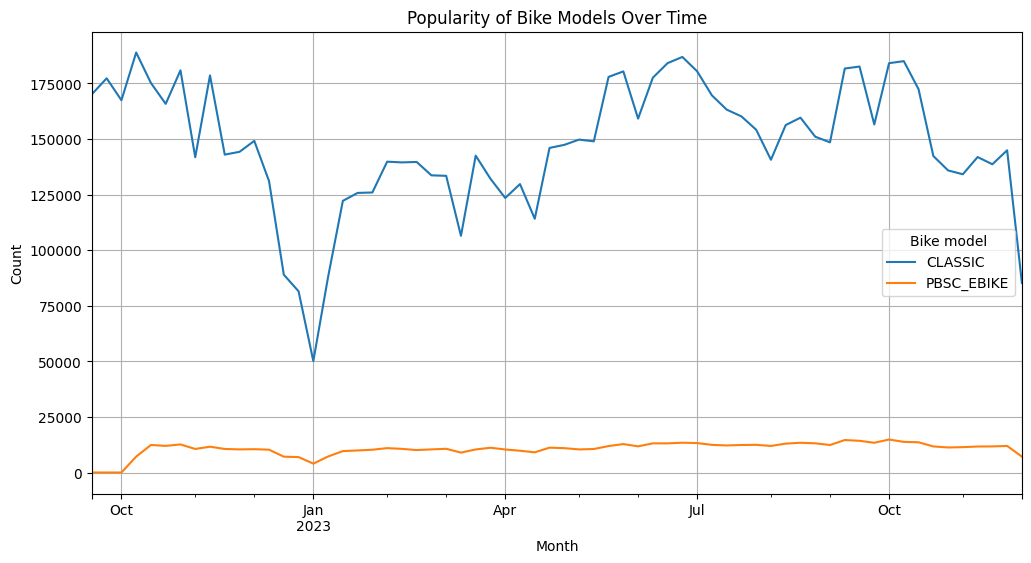

In [12]:
df['Start'] = pd.to_datetime(df['Start'])
df = df.set_index('Start')

#Drop NaN in 'Model'
df1 = df.dropna(subset=['Bike model'])

weekly_counts = df1.groupby([pd.Grouper(freq='W'), 'Bike model']).size().unstack()

#Plotting
weekly_counts.plot(kind='line', figsize=(12, 6))
plt.title('Popularity of Bike Models Over Time')
plt.xlabel('Month')
plt.ylabel('Count')
plt.grid(True)
plt.show()

It appears the classic bike models are still comfortably in the lead, with e-bikes having a lower but steadier stream of usage. Whilst the trend line shows a small decline towards the end, it would appear there are customers who are particularly fond of the e-bike model, given the relative flatline over 2023 for usage.

It would also be helpful to see how bicycle usage is trending over time.

NaN entries for Number ID:  0

Number of unique entries for Number ID:  28801107



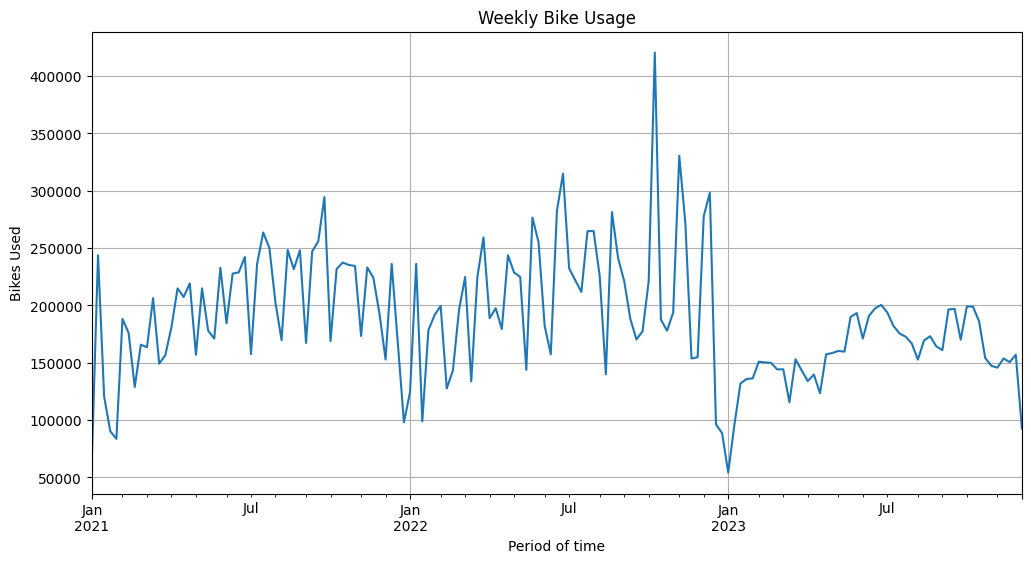

In [16]:
#ensuring no NaN values
print('NaN entries for Number ID: ', df['Number ID'].isna().sum())

print()
#confirming Number ID is an arbirtrary transaction ID
assert len(df['Number ID'].unique()) == df.shape[0]
print('Number of unique entries for Number ID: ', len(df['Number ID'].unique()))

print()

weekly_bike_usage = df.groupby(pd.Grouper(freq='W'))['Number ID'].nunique()

# Plotting
weekly_bike_usage.plot(kind='line', figsize=(12, 6))
plt.title('Weekly Bike Usage')
plt.xlabel('Period of time')
plt.ylabel('Bikes Used')
plt.grid(True)
plt.show()


In [21]:
weekly_bike_usage.isna().sum()

0

With this in mind, I will now carry out a basic time series analysis to understand the trends of this data. Inspecting the features, it appears that something like a regression model for bicycle usage will not be an effective application. I will trial this later to confirm suspicions.

ADF Statistic: -2.969511
p-value: 0.037841


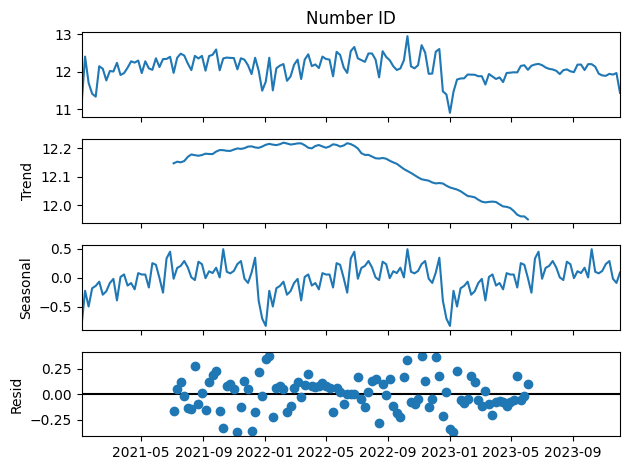

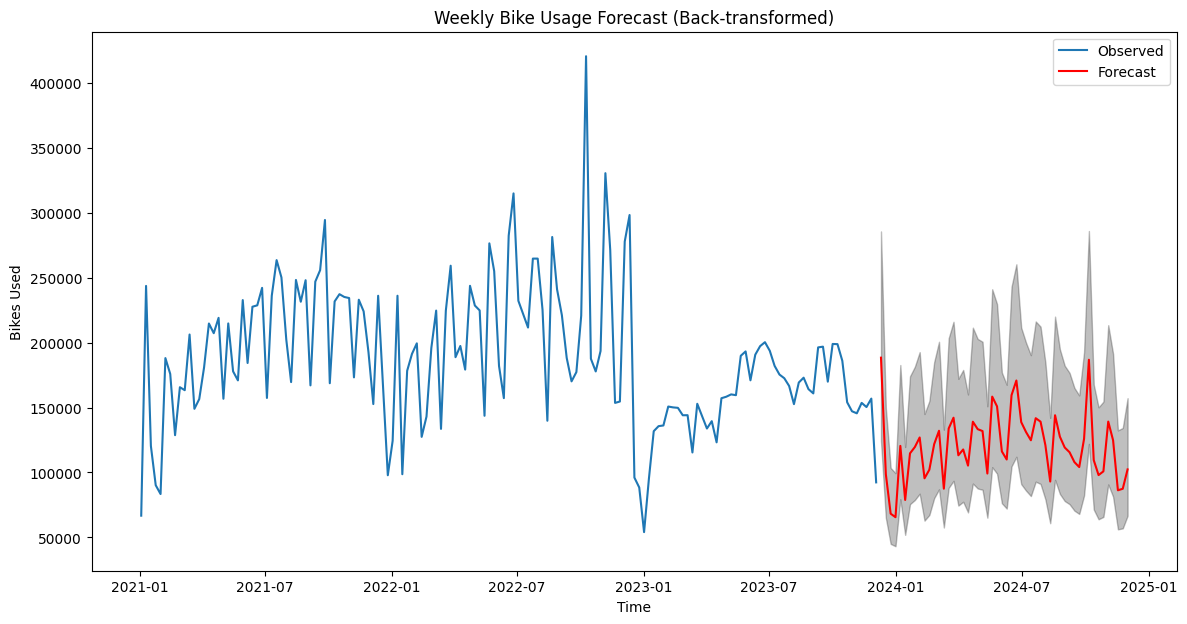

In [24]:
#time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

shift = 1
weekly_bike_usage_shifted = weekly_bike_usage + shift

weekly_bike_usage_log = np.log(weekly_bike_usage_shifted)

#stationarity?
result = adfuller(weekly_bike_usage_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

#check pvalue
if result[1] > 0.05:
    weekly_bike_usage_diff = weekly_bike_usage_log.diff().dropna()
else:
    weekly_bike_usage_diff = weekly_bike_usage_log

decomposition = seasonal_decompose(weekly_bike_usage_diff, model='additive')


model = SARIMAX(weekly_bike_usage_diff,
                order=(1, 0, 1),
                seasonal_order=(1, 1, 0, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

forecast = results.get_forecast(steps=52)
forecast_ci = forecast.conf_int()

forecast_mean_back = np.exp(forecast.predicted_mean) - shift

plt.figure(figsize=(14, 7))
plt.plot(weekly_bike_usage, label='Observed')
plt.plot(forecast_mean_back, label='Forecast', color='r')
plt.fill_between(forecast_ci.index,
                 np.exp(forecast_ci.iloc[:, 0]) - shift,
                 np.exp(forecast_ci.iloc[:, 1]) - shift, color='k', alpha=.25)
plt.title('Weekly Bike Usage Forecast (Back-transformed)')
plt.xlabel('Time')
plt.ylabel('Bikes Used')
plt.legend()
plt.show()


It seems there is a trend of the summer months being great for bicycle usage, and the winter months yielding lower activity.

The next step I believe, is to examine the start and end destinations to understand where the hotspots for this activity are.

In [14]:
def plot_top_n_places(entries, column_name):
  entries.plot(kind='bar')
  plt.title(f'Top 5 Most Common Entries in {column_name}')
  plt.xlabel('Entries')
  plt.ylabel('Frequency')
  plt.xticks(rotation=85)
  plt.show()

#examining the start station locations
print('Number of unique origin stations', len(df['Start Station'].unique()))
print('NaN entries for origin stations: ', df['Start Station'].isna().sum())
top_5_origin = df['Start Station'].value_counts().head()

print()

#examining the end locations
print('Number of unique destination stations: ', len(df['End Station'].unique()))
print('NaN entries for destination stations: ', df['End Station'].isna().sum())
top_5_destination = df['End Station'].value_counts().head()


Number of unique origin stations 828
NaN entries for origin stations:  0

Number of unique destination stations:  829
NaN entries for destination stations:  0


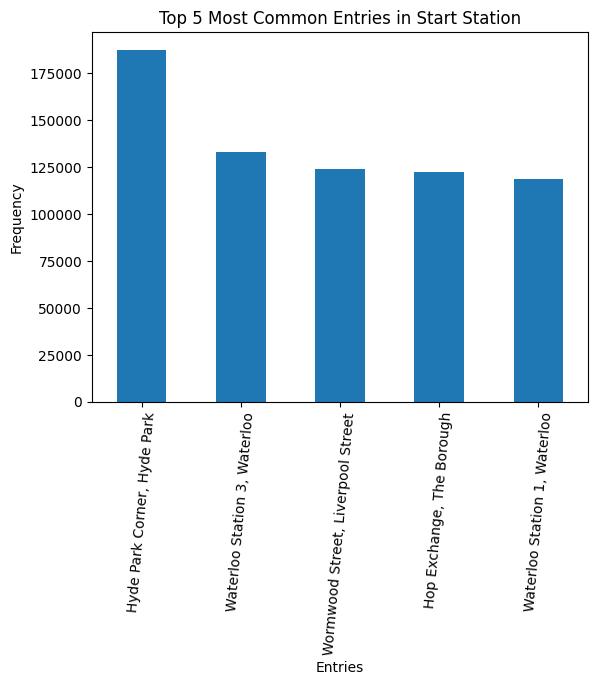

In [15]:
#the top 5 most common start stations
plot_top_n_places(top_5_origin, "Start Station")

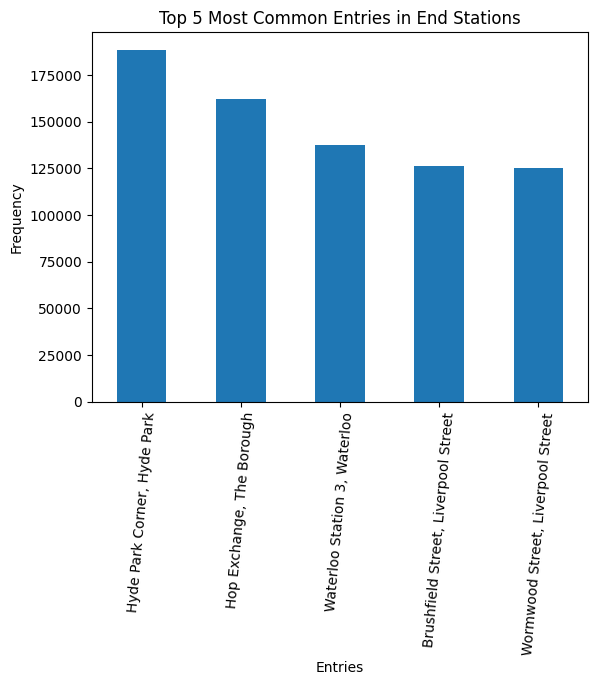

In [16]:
#the top 5 most common end stations
plot_top_n_places(top_5_destination, "End Stations")

As we can see, every item in the dataframe does have a start and end destination, with over 800 options for both.

Hyde Park is the most common start and end point, specifically Hyde Park Corner and Albert Gate, which may come as no surprise.

The two options for modelling appear to be:



*   Time series analysis/forecasting - Using a tool like an ARIMA model to forecast demand and bicycle usage to inform resource allocation. This typically follows a univariate approach and can struggle with large datasets and non-linear relationships between variables
*   LSTM Model - an advanced tool like a LSTM model can be very good for sequential prediction tasks, performs better with a larger dataset, and can help to capture any non-linear relationships between multiple variables and the usage.

It appears in this case, the LSTM model would be a better fit for the approach. But it is worth keeping in mind this will involve steps such as model tuning.


We want to ensure there are no problematic NaN values as part of the feature engineering process for our LSTM model. We already understand that 2/3 of the dataset does not have one of the bike models as a value.

In [17]:
print(df['Bike Id'].isna().sum())
print(df['Bike number'].isna().sum())
print(df['Number ID'].isna().sum())

10139671
18661436
0


In [18]:
print(df['Bike Id'].head())
print(df['Bike number'].tail())

Start
2021-03-01 14:47:00       22.0
2021-03-01 12:57:00    10755.0
2020-12-30 14:33:00    18908.0
2020-12-30 09:08:00    18499.0
2021-01-01 20:58:00     6695.0
Name: Bike Id, dtype: float64
Start
2023-11-15 00:01:00    61134.0
2023-11-15 00:01:00    23548.0
2023-11-15 00:01:00    54249.0
2023-11-15 00:00:00    57148.0
2023-11-15 00:00:00    60163.0
Name: Bike number, dtype: float64


It appears that bike id and bike number's purpose for the dataset is already covered by the number id column, meaning we can drop these columns and their problematic NaN values immediately.

Additionally, as we know that 2/3 of the bike model column do not contain one of the two models (classic or ebike), it is not sensible to impute these values as this would introduce bias to the data. We understand that over 90% of the usage belongs to classic cycles, and we can use this to draw conclusions later. So it makes sense to drop this column also due to it's problematic NaN values.

Given we have string representations of the start/end stations, it is sensible to now also drop the start/end station codes as these simply reflect the string entry in the columns. Keeping these features in is largely redundant, and can lead to multicollinearity (given the codes will have an exact relationship with the string representations of the stations).

In [19]:
df = df.drop(columns=['Bike Id', 'Bike number', 'Bike model','Start station code', 'End station code'], axis=1)
df.head()

,Number ID,End,Start Station,End Station,Duration(Minutes)
Start,,,,,
2021-03-01 14:47:00,104820582.0,2021-03-01 15:14:00,"Salmon Lane, Limehouse","Brunswick Square, Bloomsbury",27.0
2021-03-01 12:57:00,104816169.0,2021-03-01 13:26:00,"New Fetter Lane, Holborn","Salmon Lane, Limehouse",29.0
2020-12-30 14:33:00,104757113.0,2020-12-30 15:00:00,"Houndsditch, Aldgate","Warren Street Station, Euston",27.0
2020-12-30 09:08:00,104749458.0,2020-12-30 09:21:00,"Simpson Street, Clapham Junction","Ram Street, Wandsworth",13.0
2021-01-01 20:58:00,104792584.0,2021-01-01 21:02:00,"Crabtree Lane, Fulham","Crisp Road, Hammersmith",4.0


We now have to deal with the start/end station features, as they are strings and need to be encoded to be processed by our LSTM. Steps like one-hot encoding is not practical given there are over 800 different values for each column. This would dramatically increase the dimensions of the dataset and potentially incur the curse of dimensionality.

There is also important feature engineering steps to make sure we get the most out of our start/end time

In [20]:
#getting specific hour
df['hour'] = df.index.hour

In [21]:
#encoding categorical features as discussed earlier, using embedding to avoid high dimensionality
encoder = LabelEncoder()
df['Start Station Encoded'] = encoder.fit_transform(df['Start Station'])
df['End Station Encoded'] = encoder.fit_transform(df['End Station'])

# Scaling numerical features
scaler = MinMaxScaler()
df['Duration(Minutes)'] = scaler.fit_transform(df[['Duration(Minutes)']])

#dropping string representation of stations
df = df.drop(columns=['Start Station', 'End Station'], axis=1)

In [28]:
df.head()

,Number ID,End,Duration(Minutes),hour,Start Station Encoded,End Station Encoded
Start,,,,,,
2021-03-01 14:47:00,104820582.0,2021-03-01 15:14:00,0.562500,14,624,109
2021-03-01 12:57:00,104816169.0,2021-03-01 13:26:00,0.604167,12,492,625
2020-12-30 14:33:00,104757113.0,2020-12-30 15:00:00,0.562500,14,374,778
2020-12-30 09:08:00,104749458.0,2020-12-30 09:21:00,0.270833,9,647,593
2021-01-01 20:58:00,104792584.0,2021-01-01 21:02:00,0.083333,20,187,193


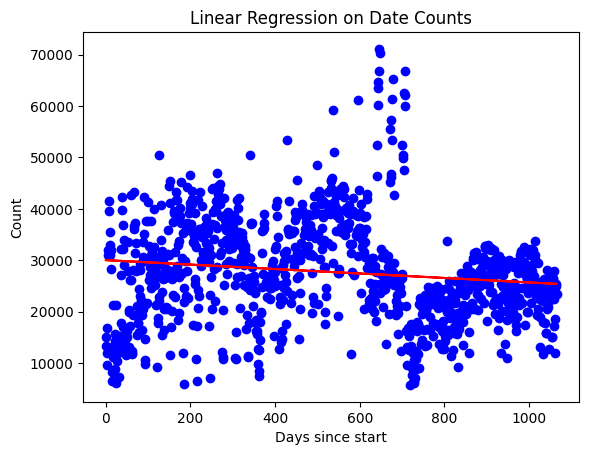

In [30]:
from sklearn.linear_model import LinearRegression

df.index = df.index.date

# Count occurrences of each date
date_counts = df.index.value_counts()


df_dates = pd.DataFrame({'date': date_counts.index})
df_dates['date_numeric'] = (pd.to_datetime(df_dates['date']) - pd.to_datetime(df_dates['date']).min()).dt.days


X = df_dates['date_numeric'].values.reshape(-1, 1)
y = date_counts.values


model = LinearRegression()
model.fit(X, y)

# Predict and plot
y_pred = model.predict(X)
plt.scatter(X, y, color='blue')
plt.plot(X, y_pred, color='red')
plt.xlabel('Days since start')
plt.ylabel('Count')
plt.title('Linear Regression on Date Counts')
plt.show()

After cleaning and feature engineering the dataset, it is difficult to implement most machine learning models to this problem set, as these variables are mostly unlikely to describe much about the frequency of bicycle rentals. Helpful data would include tools like temperature, or other information surrounding the day.

The regression simple model shows that these models would not be able to capture a key understanding of the dataset. This plot shows there is not a linear relationship with the days of the week and the count of rental occurences.

In this case, I believe a simple time series analysis of bike usage is the most effective route ahead given our data.
